# Chapter 8: Conditional GAN

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Embedding, Flatten, Input, Multiply, Reshape, Dropout)
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam

import session_info
session_info.show()

In [3]:
np.random.seed(42)
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

## Generator

In [5]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

In [6]:
def build_cgan_generator(z_dim):

    # Random noise vector z
    z = Input(shape=(z_dim, ))

    # Conditioning label: integer 0-9 specifying the number G should generate
    label = Input(shape=(1, ), dtype='int32')

    # Label embedding:
    # ----------------
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape (batch_size, 1, z_dim)
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

    # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, z_dim)
    label_embedding = Flatten()(label_embedding)

    # Element-wise product of the vectors z and the label embeddings
    joined_representation = Multiply()([z, label_embedding])

    generator = build_generator(z_dim)

    # Generate image for the given label
    conditioned_img = generator(joined_representation)

    return Model([z, label], conditioned_img)

## Discriminator

In [8]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x2 into 14x14x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x64 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    #model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    #model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [9]:
def build_cgan_discriminator(img_shape):

    # Input image
    img = Input(shape=img_shape)

    # Label for the input image
    label = Input(shape=(1, ), dtype='int32')

    # Label embedding:
    # ----------------
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape (batch_size, 1, 28*28*1)
    label_embedding = Embedding(num_classes,
                                np.prod(img_shape),
                                input_length=1)(label)

    # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, 28*28*1)
    label_embedding = Flatten()(label_embedding)

    # Reshape label embeddings to have same dimensions as input images
    label_embedding = Reshape(img_shape)(label_embedding)

    # Concatenate images with their label embeddings
    concatenated = Concatenate(axis=-1)([img, label_embedding])

    discriminator = build_discriminator(img_shape)

    # Classify the image-label pair
    classification = discriminator(concatenated)

    return Model([img, label], classification)

## Build the Model

In [11]:
def build_cgan(generator, discriminator):

    # Random noise vector z
    z = Input(shape=(z_dim, ))

    # Image label
    label = Input(shape=(1, ))

    # Generated image for that label
    img = generator([z, label])

    classification = discriminator([img, label])

    # Combined Generator -> Discriminator model
    # G([z, lablel]) = x*
    # D(x*) = classification
    model = Model([z, label], classification)

    return model

In [12]:
# Build and compile the Discriminator
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_cgan_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile CGAN model with fixed Discriminator to train the Generator
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

## Training

In [14]:
accuracies = []
losses = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, y_train), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images and their labels
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels], verbose=0)

        # Train the Discriminator
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of noise vectors
        z = np.random.normal(0, 1, (batch_size, z_dim))

        # Get a batch of random labels
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        # Train the Generator
        g_loss = cgan.train_on_batch([z, labels], real)

        if (iteration + 1) % sample_interval == 0:

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            # Output sample of generated images
            sample_images()

In [15]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-9
    labels = np.arange(0, 10).reshape(-1, 1)

    # Generate images from random noise
    gen_imgs = generator.predict([z, labels], verbose=0)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

# Train the Model and Inspect Training Progress

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

1000 [D loss: 0.055678, acc.: 98.24%] [G loss: 7.099845]


C:\Users\silve\AppData\Local\Temp\ipykernel_22952\43058714.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i, j].set_title("Digit: %d" % labels[cnt])


2000 [D loss: 0.107624, acc.: 96.19%] [G loss: 4.881665]
3000 [D loss: 0.307499, acc.: 87.60%] [G loss: 2.230199]
4000 [D loss: 0.492132, acc.: 77.54%] [G loss: 1.274550]
5000 [D loss: 0.485764, acc.: 75.88%] [G loss: 1.350915]
6000 [D loss: 0.519989, acc.: 74.32%] [G loss: 1.867539]
7000 [D loss: 0.439578, acc.: 77.73%] [G loss: 1.435190]
8000 [D loss: 0.391013, acc.: 81.05%] [G loss: 1.808227]
9000 [D loss: 0.404706, acc.: 81.35%] [G loss: 1.525923]
10000 [D loss: 0.411717, acc.: 79.59%] [G loss: 1.803988]
11000 [D loss: 0.480328, acc.: 74.90%] [G loss: 1.468890]
12000 [D loss: 0.430745, acc.: 79.00%] [G loss: 1.651316]
13000 [D loss: 0.408683, acc.: 79.88%] [G loss: 1.820408]
14000 [D loss: 0.474670, acc.: 75.78%] [G loss: 1.636434]
15000 [D loss: 0.426478, acc.: 79.10%] [G loss: 1.659528]
16000 [D loss: 0.513201, acc.: 73.73%] [G loss: 1.664425]
17000 [D loss: 0.447890, acc.: 78.22%] [G loss: 1.781270]
18000 [D loss: 0.462800, acc.: 75.39%] [G loss: 1.624567]
19000 [D loss: 0.42437

C:\Users\silve\AppData\Local\Temp\ipykernel_22952\43058714.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(image_grid_rows,


22000 [D loss: 0.431845, acc.: 78.91%] [G loss: 1.799107]
23000 [D loss: 0.504946, acc.: 75.00%] [G loss: 1.501889]
24000 [D loss: 0.470467, acc.: 75.88%] [G loss: 1.417028]
25000 [D loss: 0.492125, acc.: 74.02%] [G loss: 1.322679]
26000 [D loss: 0.516124, acc.: 72.66%] [G loss: 1.309668]
27000 [D loss: 0.499625, acc.: 73.54%] [G loss: 1.379127]
28000 [D loss: 0.480247, acc.: 74.41%] [G loss: 1.488602]
29000 [D loss: 0.487780, acc.: 74.51%] [G loss: 1.455537]
30000 [D loss: 0.485106, acc.: 75.10%] [G loss: 1.531453]
31000 [D loss: 0.503107, acc.: 73.54%] [G loss: 1.361131]
32000 [D loss: 0.528220, acc.: 73.63%] [G loss: 1.307246]
33000 [D loss: 0.527799, acc.: 71.48%] [G loss: 1.566159]
34000 [D loss: 0.505499, acc.: 73.73%] [G loss: 1.335402]
35000 [D loss: 0.468433, acc.: 74.32%] [G loss: 1.365819]
36000 [D loss: 0.473969, acc.: 76.07%] [G loss: 1.329397]
37000 [D loss: 0.480316, acc.: 75.68%] [G loss: 1.426241]
38000 [D loss: 0.499439, acc.: 73.73%] [G loss: 1.323474]
39000 [D loss:

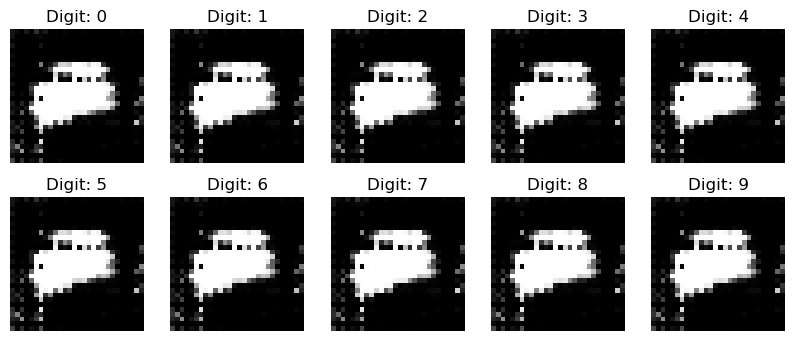

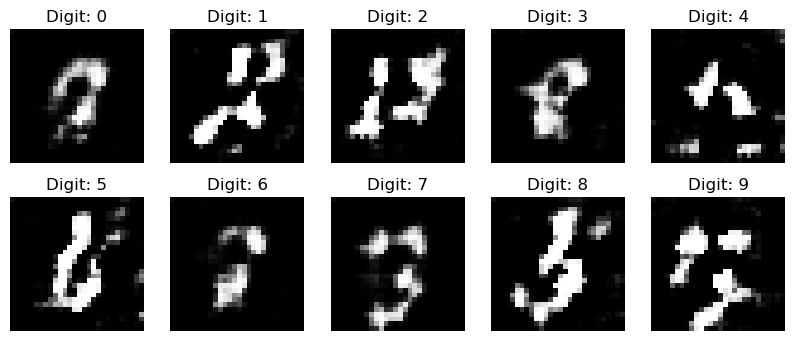

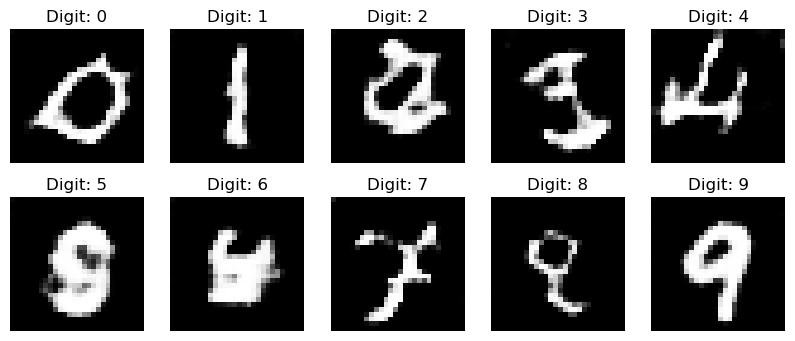

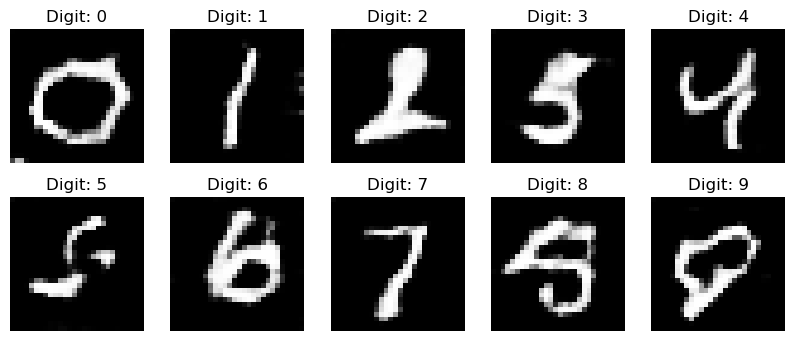

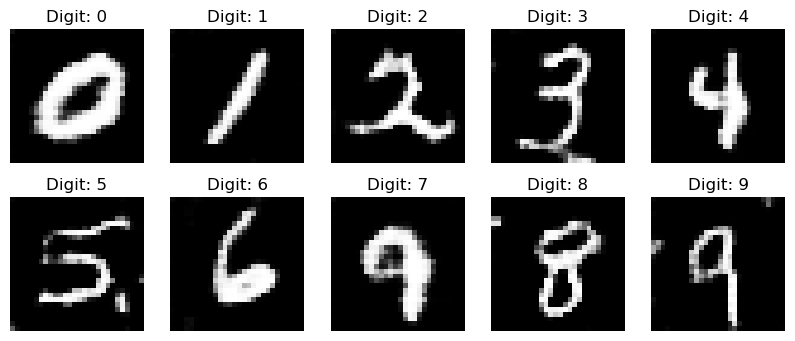

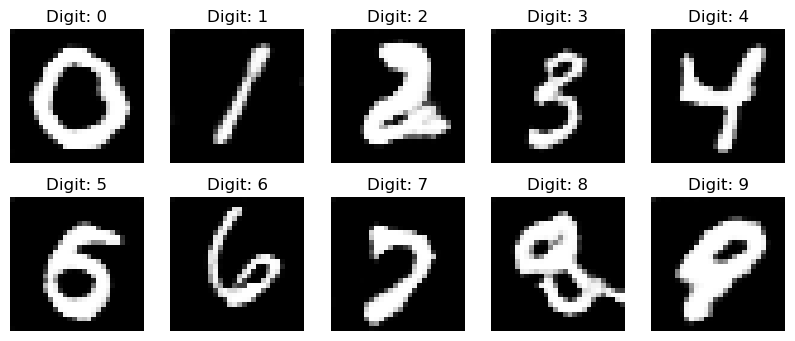

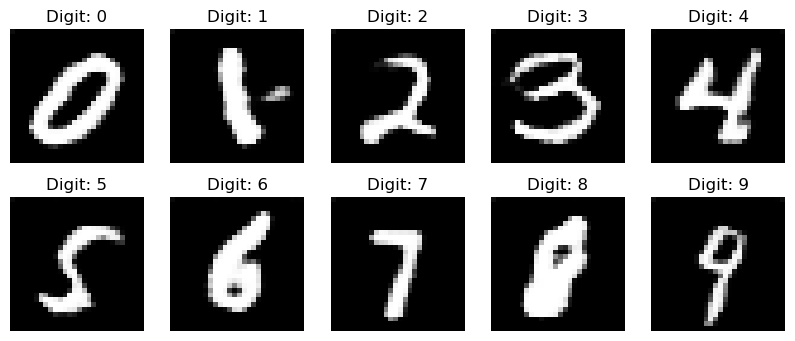

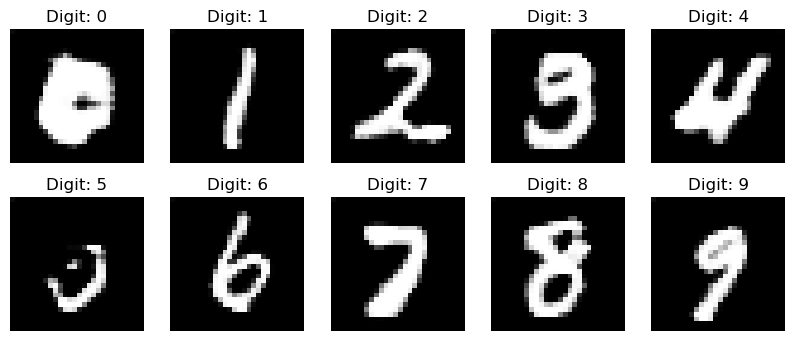

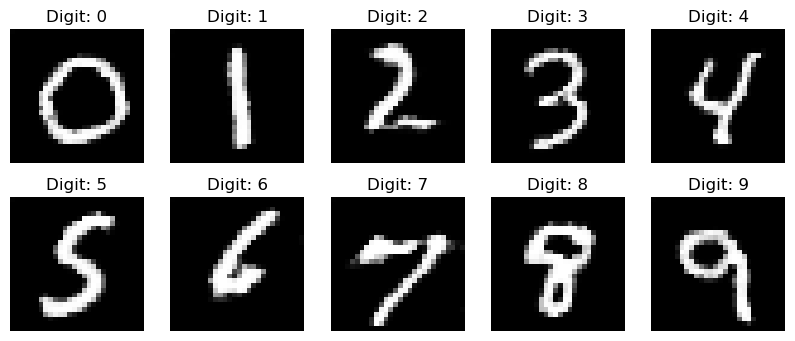

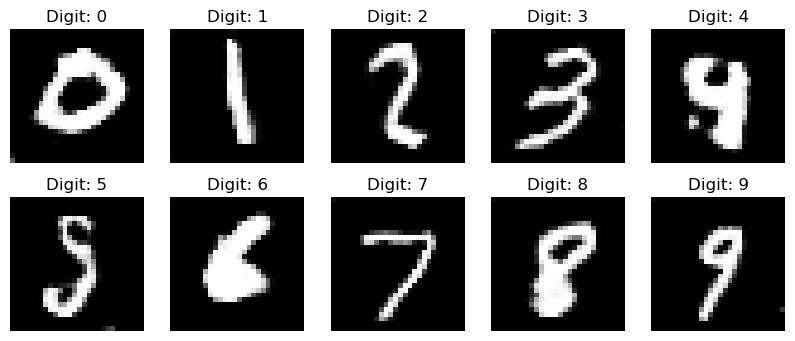

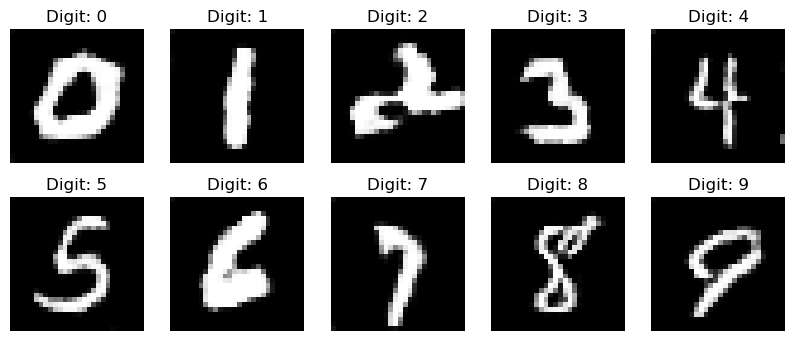

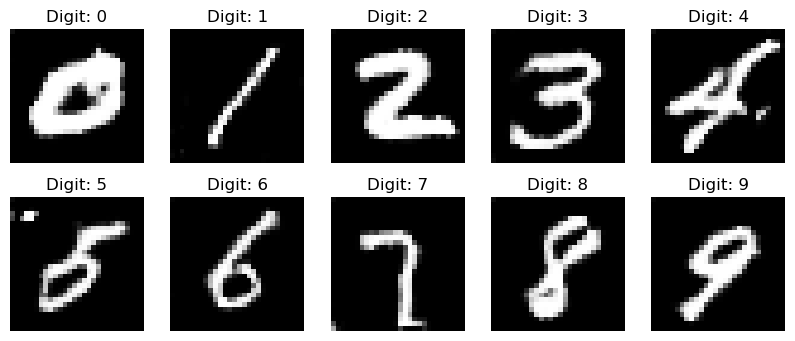

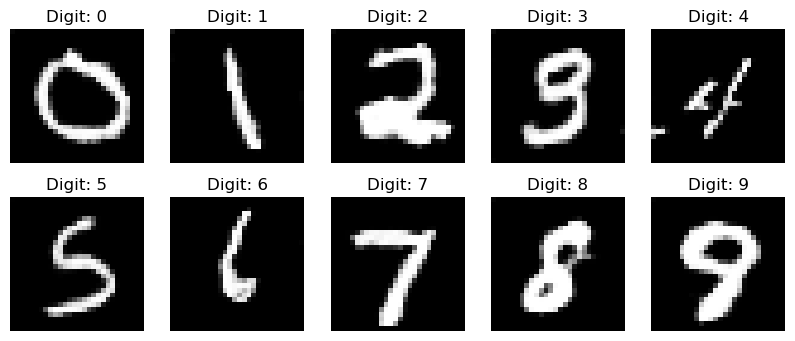

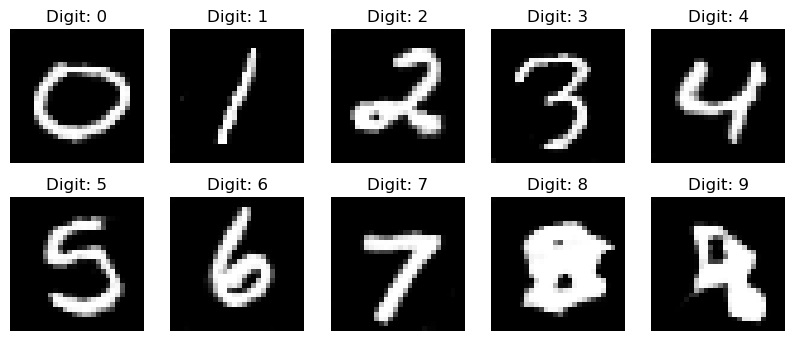

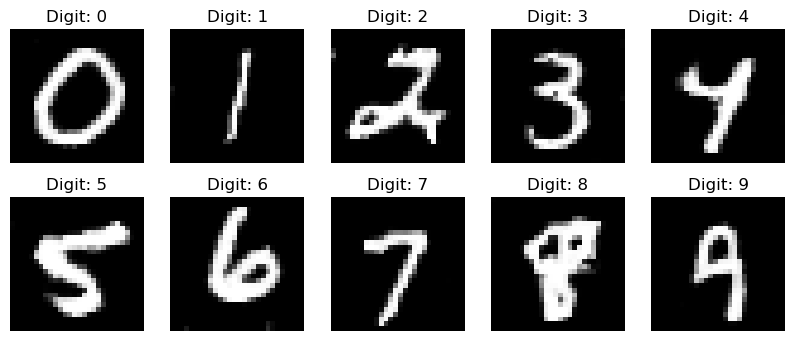

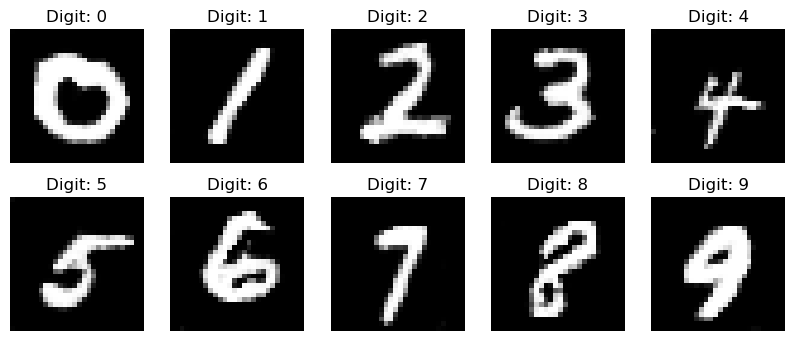

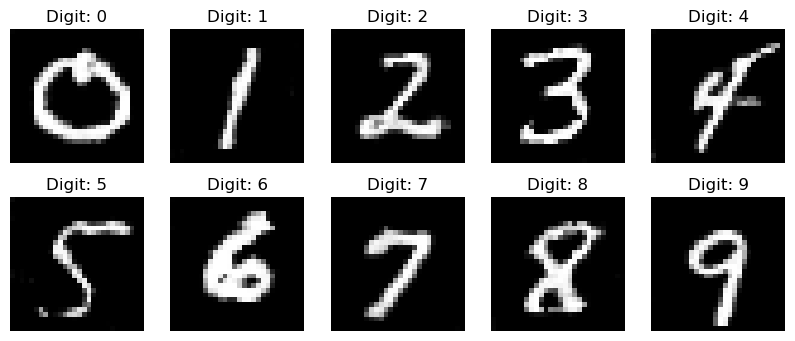

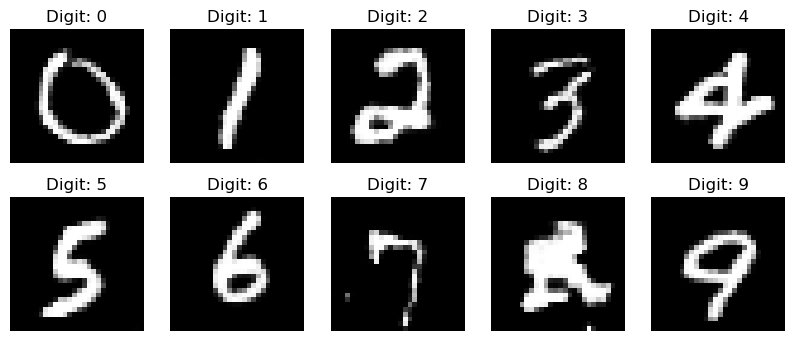

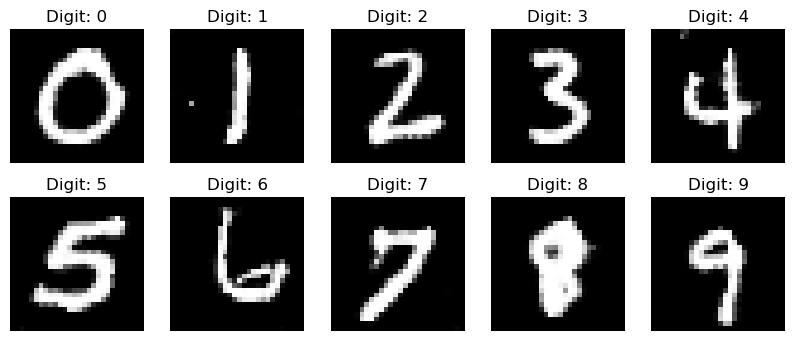

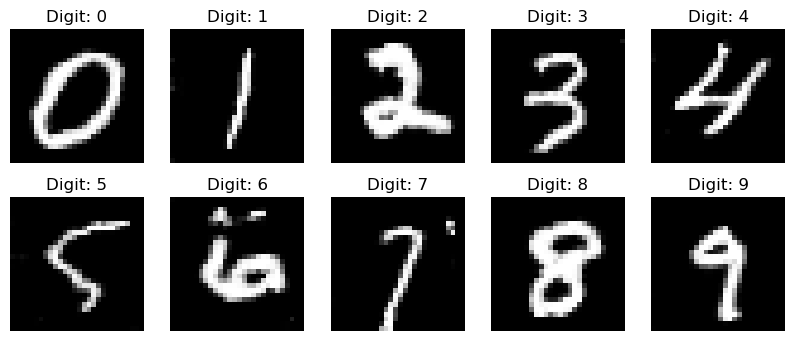

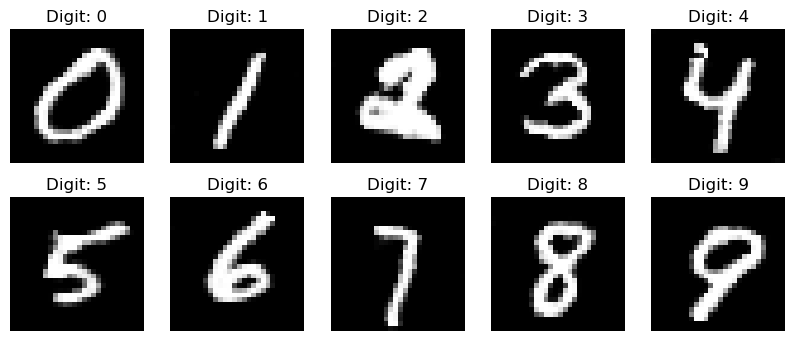

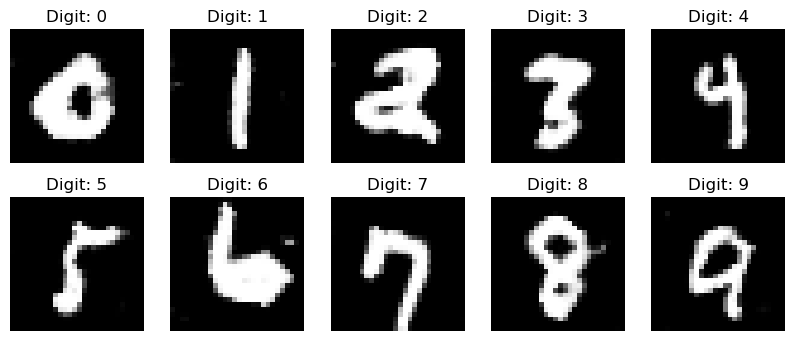

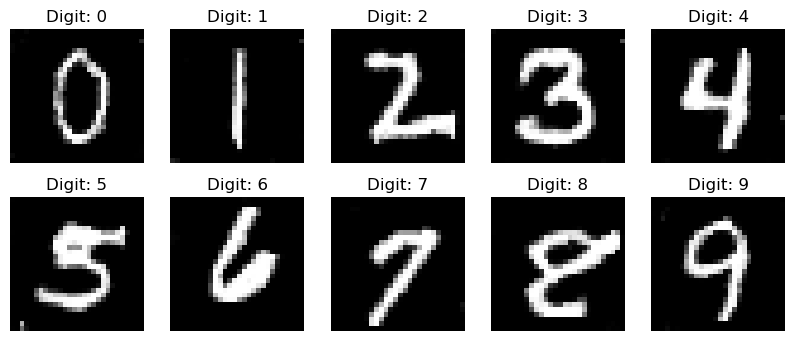

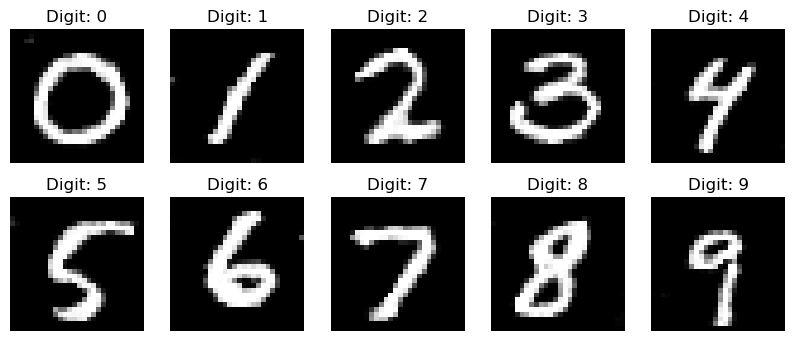

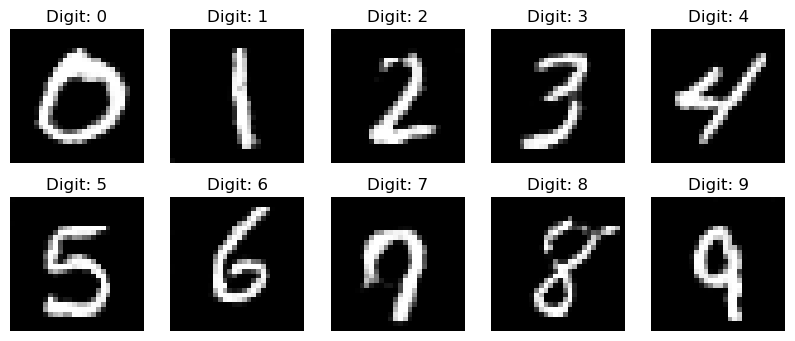

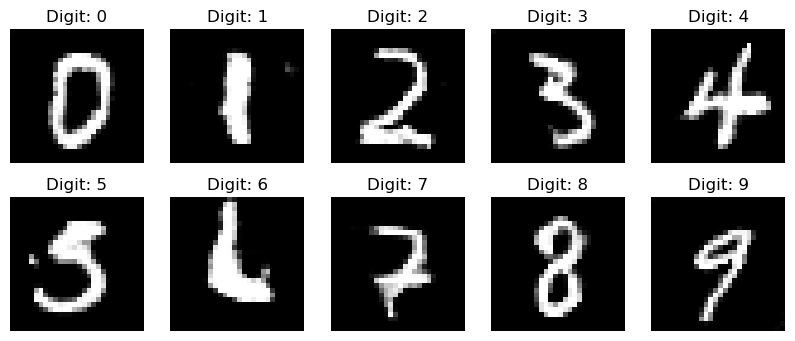

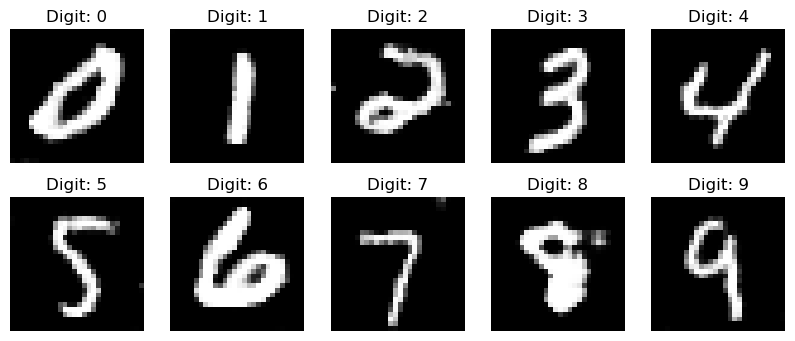

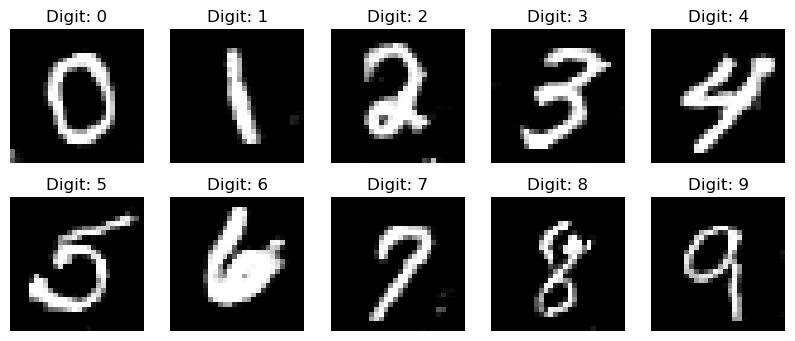

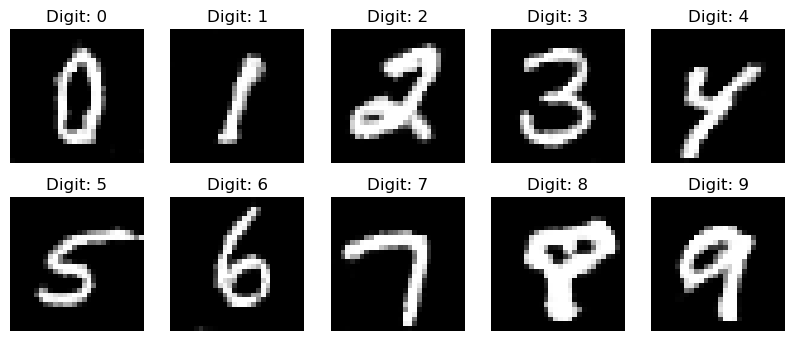

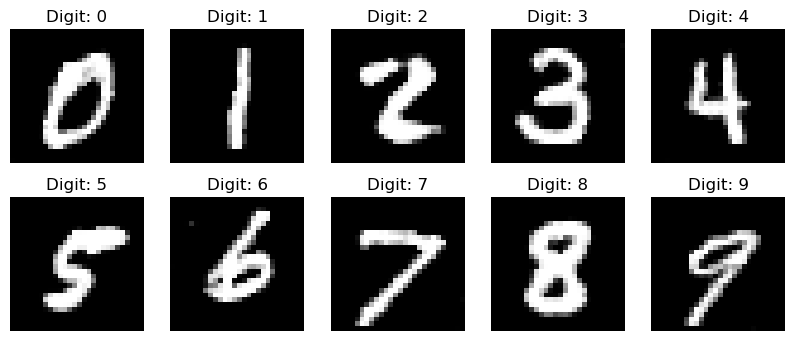

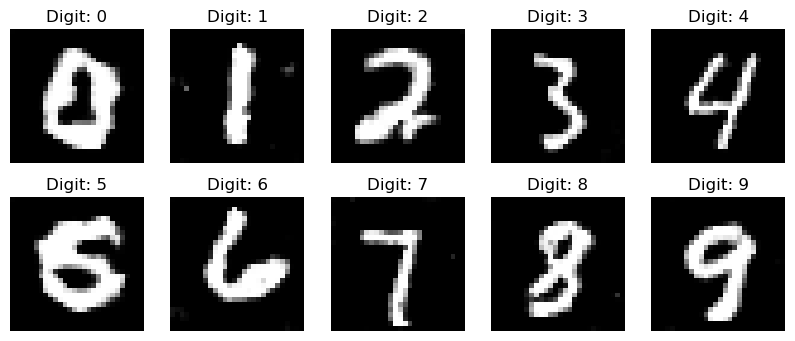

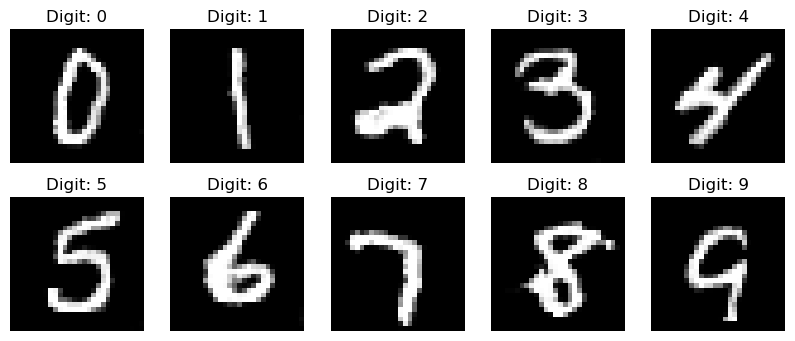

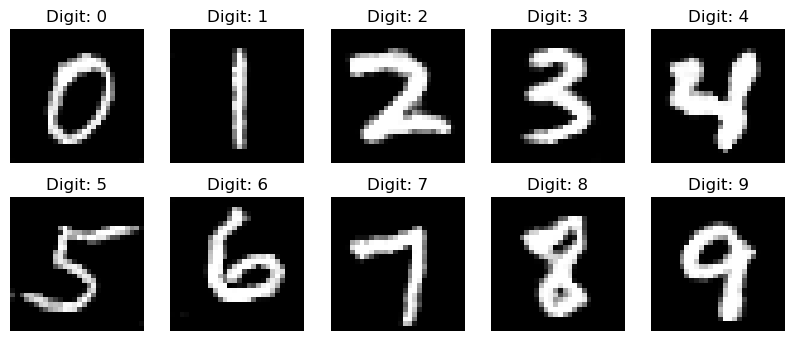

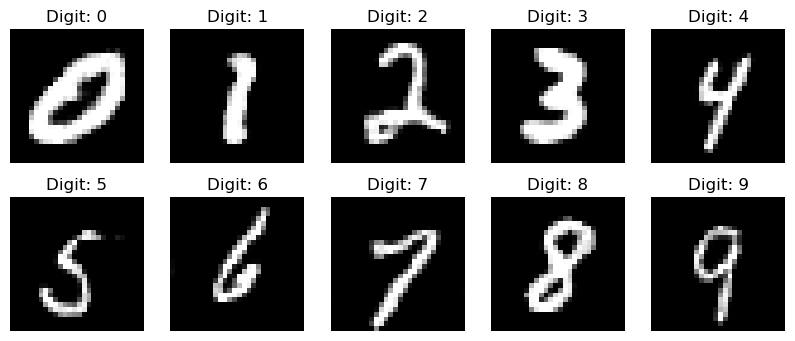

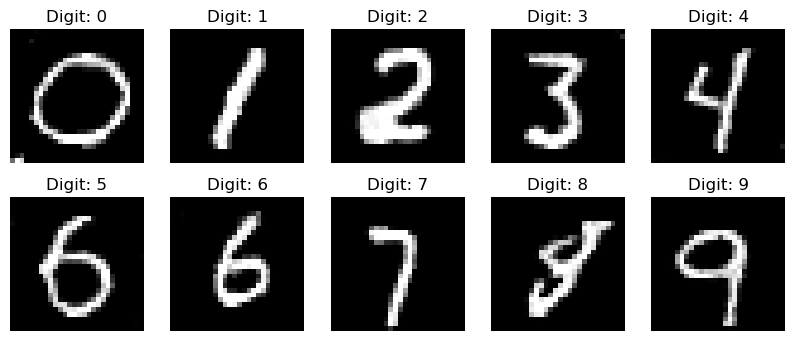

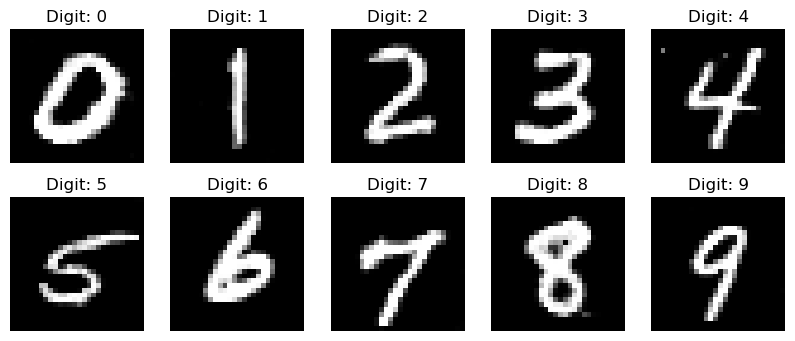

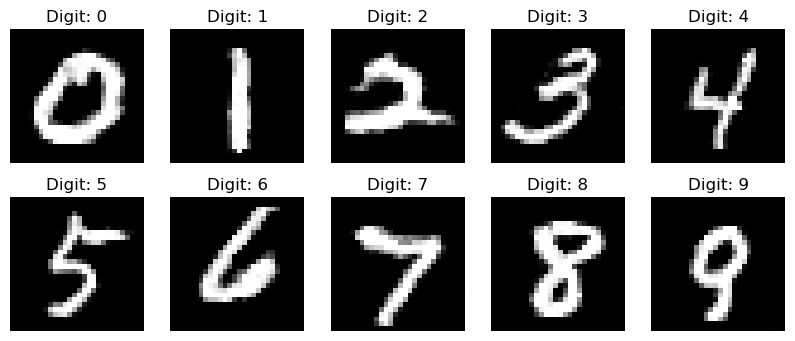

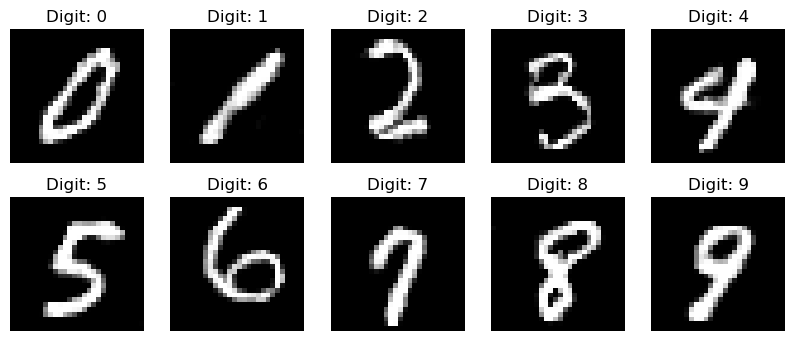

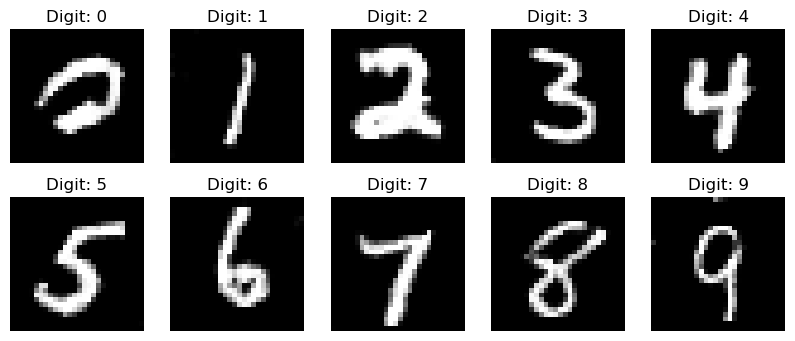

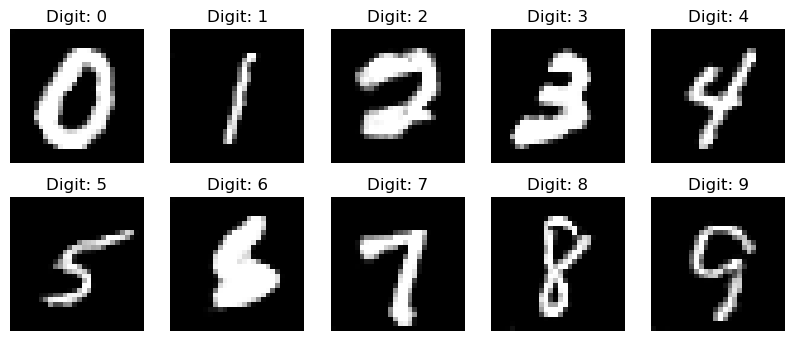

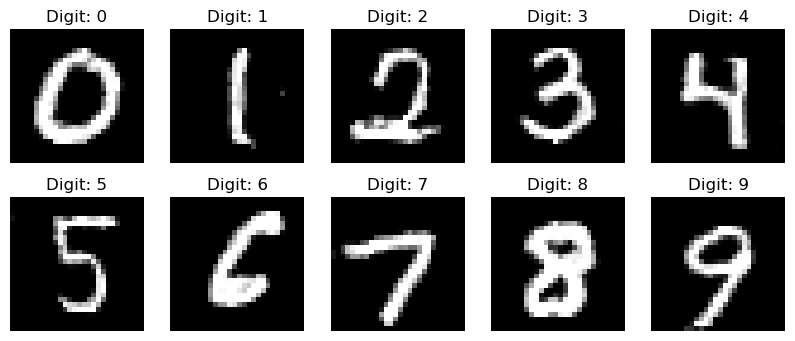

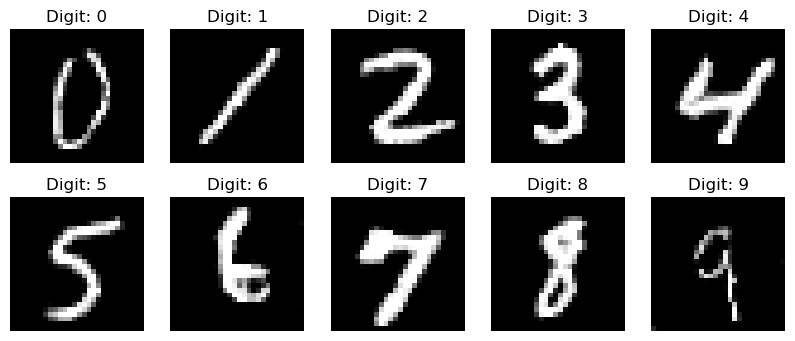

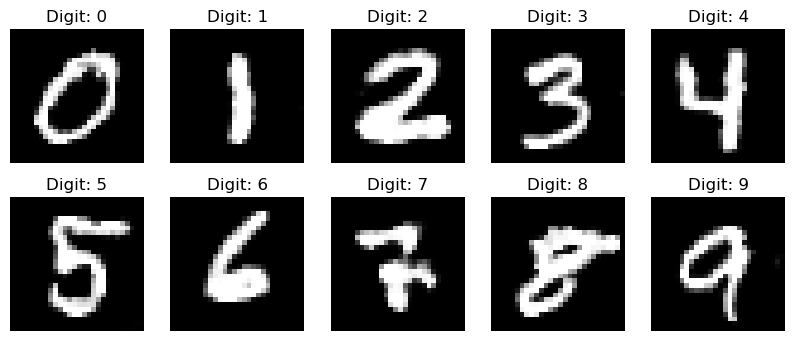

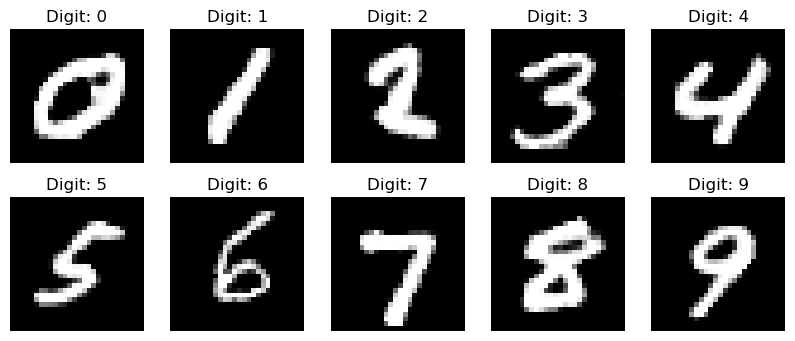

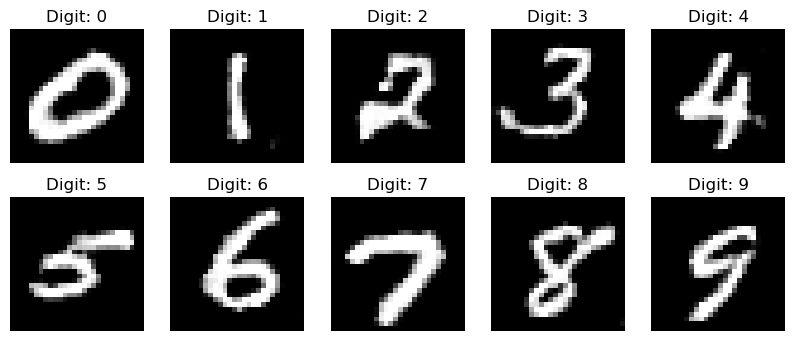

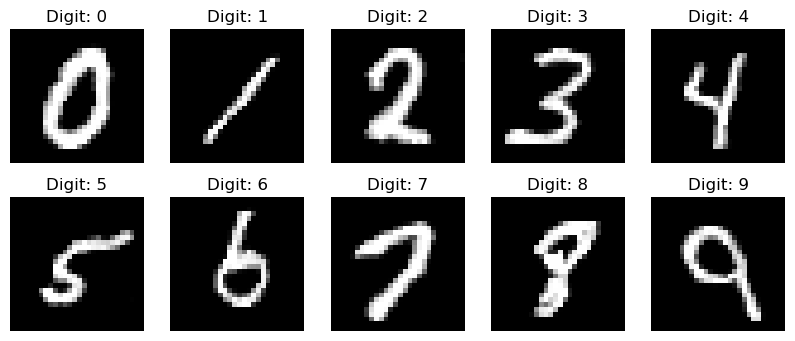

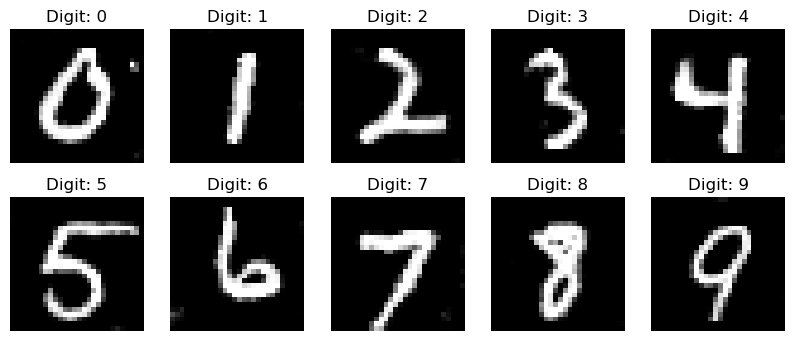

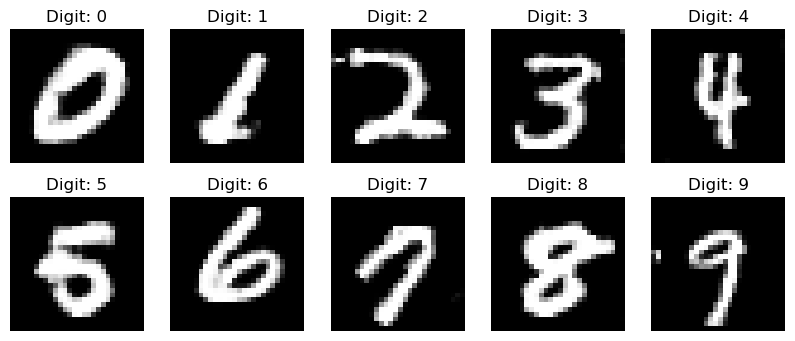

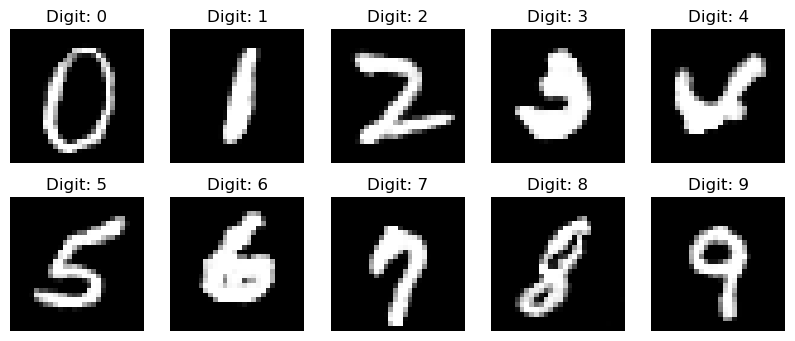

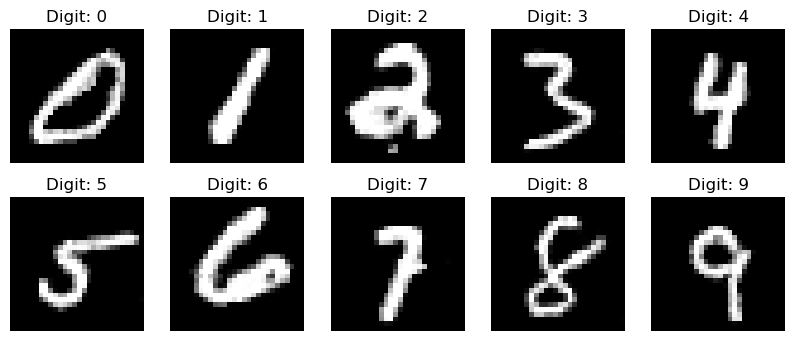

In [18]:
# Set hyperparameters
iterations = 50000
batch_size = 512
sample_interval = 1000

# Train the CGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

# Output from a Trained CGAN Model

2/2 [==============================] - 0s 87ms/step


C:\Users\silve\AppData\Local\Temp\ipykernel_22952\4015409499.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW


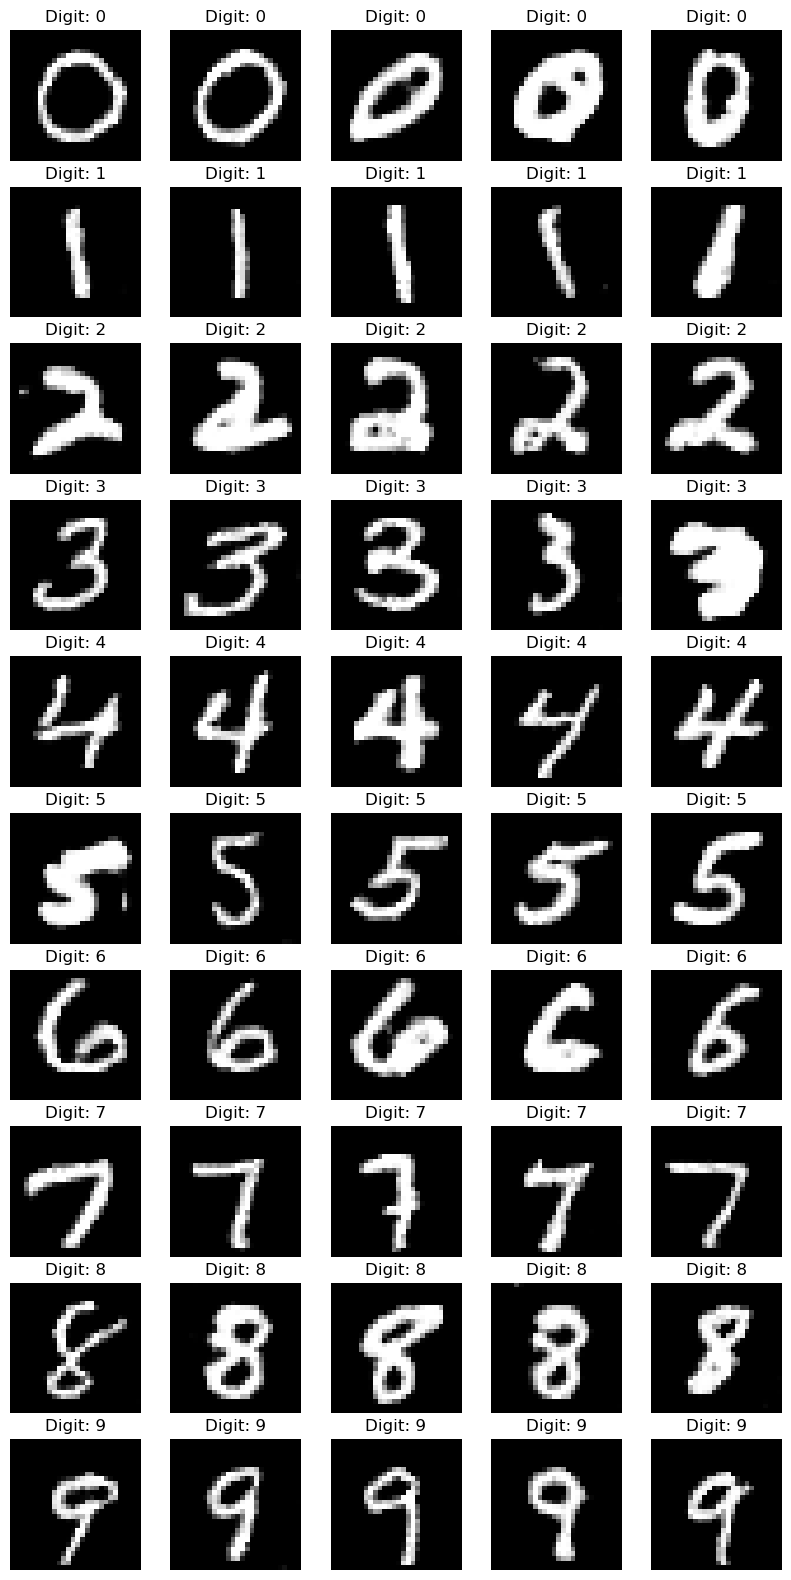

In [20]:
# Set grid dimensions
image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# Get image labels to generate: 5 samples for each label
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# Generate images from random noise
gen_imgs = generator.predict([z, labels_to_generate])

# Rescale image pixel values to [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output a grid of images
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1

----

In [22]:
#this is too alert me when it finishes
import winsound 
 
# frequency is set to 524Hz
freq = 524
 
# duration is set to 1.5 seconds             
dur = 1500
              
winsound.Beep(freq, dur)